In this work, we utilized a Word2Vec model to generate vector representations of IPA segments, inspired by the approach described in the paper “IPA Alignment Using Vector Representations” by Pavel Sofroniev and Çağri Çöltekin(https://github.com/pavelsof/ipavec/blob/master/paper/thesis.pdf). The Word2Vec model was trained specifically for generating these vector representations and is based on the methodology provided in their research.

In [1]:
!pip install gensim
!pip install ipatok
!pip install seaborn
!pip install matplotlib
!pip install geopy
!pip install scipy

In [2]:
import pandas as pd
from gensim.models import Word2Vec
from google.colab import drive
import os
import warnings
from ipatok.ipa import is_letter, is_tie_bar
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import great_circle
from scipy.stats import pearsonr, spearmanr

In [3]:
# Mount Google Drive
drive.mount('/content/gdrive')
forms = pd.read_csv("/content/gdrive/My Drive/Data Science/forms.csv")
# Check the data
forms

Mounted at /content/gdrive


,ID,Local_ID,Language_ID,Parameter_ID,Value,Form,Segments,Comment,Source,Cognacy,Loan,Graphemes,Profile,Prosody,Morpheme_Glosses,Partial_Cognacy,Chinese_Characters
0,Beijing-91_vomit-1,NaN,Beijing,91_vomit,tʰu⁵¹,tʰu⁵¹,tʰ u ⁵¹,NaN,Liu2007,NaN,NaN,NaN,NaN,i n t,spit/吐,1,吐
1,Haerbin-91_vomit-1,NaN,Haerbin,91_vomit,tʰu⁵³,tʰu⁵³,tʰ u ⁵³,NaN,Liu2007,NaN,NaN,NaN,NaN,i n t,spit/吐,1,吐
2,Jinan-91_vomit-1,NaN,Jinan,91_vomit,tʰu³¹,tʰu³¹,tʰ u ³¹,NaN,Liu2007,NaN,NaN,NaN,NaN,i n t,spit/吐,1,吐
3,Rongcheng-91_vomit-1,NaN,Rongcheng,91_vomit,ou²¹³⁻³⁵ tʰu²¹⁴,ou²¹³⁻³⁵ tʰu²¹⁴,ou ²¹³ + tʰ u ²¹⁴,copulative synonyme,Liu2007,NaN,NaN,NaN,NaN,n t + i n t,nausea/嘔 spit/吐,2 1,嘔 吐
4,Taiyuan-91_vomit-1,NaN,Taiyuan,91_vomit,tʰu⁵³ lə⁰,tʰu⁵³ lə⁰,tʰ u ⁵³ + l ə ⁰,NaN,Liu2007,NaN,NaN,NaN,NaN,i n t + i n t,nausea/嘔 _:PERFECTIVE/了,2 5,嘔 嘞
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4297,Guangzhou-90_woman-1,NaN,Guangzhou,90_woman,nøy²³ iɐn²¹⁻²³,nøy²³ iɐn²¹⁻²³,n øy ²³ + j ɐ n ²¹,NaN,Liu2007,NaN,NaN,NaN,NaN,i n t + i n c t,female/女 _person/人,39 38,女 人
4298,Fuzhou-90_woman-1,NaN,Fuzhou,90_woman,i⁵⁵⁻⁵³ tsia³²,i⁵⁵⁻⁵³ tsia³²,i ⁵⁵ + ts j a ³²,NaN,Liu2007,NaN,NaN,NaN,NaN,n t + i m n t,woman/伊 sister/姐,824 715,伊 姐
4299,Fuzhou-90_woman-2,NaN,Fuzhou,90_woman,ny³²⁻⁵⁵ ɛ²¹²,ny³²⁻⁵⁵ ɛ²¹²,n y ³² + ɛ ²¹²,NaN,Liu2007,NaN,NaN,NaN,NaN,i n t + n t,female/女 _world/界,39 825,女 界
4300,Fuzhou-90_woman-3,NaN,Fuzhou,90_woman,tsy⁵⁵ nøyŋ⁵³⁻⁵⁵ nøyŋ⁵³,tsy⁵⁵ nøyŋ⁵³⁻⁵⁵ nøyŋ⁵³,ts y ⁵⁵ + n øy ŋ ⁵³ + n øy ŋ ⁵³,NaN,Liu2007,NaN,NaN,NaN,NaN,i n t + i n c t + i n c t,woman/諸 female/娘 _person/人,749 31 38,諸 娘 儂


In [11]:
# Training a word2vec model to generate the vector representations of IPA segments
# First, we'll use the traget data conmbined with the annotated chinese dialets data
# as the training data, for the model's only purpose is to generate the embedding for the
# target data, so overfitting is not a problem.


def normalise_token(token):
	return ''.join([char for char in token
					if not is_tie_bar(char) and char != '◌̯'[1]])

def read_from_dir(dataset_path):
  # Initialize a list to store the result
  ipa_data = []
  # Iterate over all the file in the dir
  for file in os.listdir(dataset_path):
    file_path = os.path.join(dataset_path, file)
    # Check if the file is in tsv form
    if os.path.isfile(file_path) and file_path.endswith('.tsv'):
      # Read and process the ipa
      with open(file_path, encoding='utf-8') as f:
        for line in f:
          col = line.strip().split('\t')
          if col[0] == 'language':
            continue
          # The IPA tokens is the 6th column of the tsv table
          tokens = col[5]
          ipa_data.append(normalise_token(tokens).strip())
  return ipa_data

# Read from the target data
form = forms['Form']
tar_data = []
for ipa in form:
  if pd.notna(ipa):
    seg = [normalise_token(ipa).strip()]
    tar_data.append(seg)
# Supply non-chinese data
ipa = []
with open("/content/gdrive/My Drive/Data Science/ipa.txt", "r") as f:
  for line in f:
    line = ''.join(line.split())
    ipa.append(normalise_token(line).strip())
# print(ipa)

dir_data = read_from_dir("/content/gdrive/My Drive/Data Science/data")
ipa_data = tar_data
# Add target data and the extra training data together
ipa_data.extend(dir_data)
ipa_data.extend(ipa)
print(len(ipa_data)) # 132337
ipa_data


132337


[['tʰu⁵¹'],
 ['tʰu⁵³'],
 ['tʰu³¹'],
 ['ou²¹³⁻³⁵ tʰu²¹⁴'],
 ['tʰu⁵³ lə⁰'],
 ['ŋou²¹ tʰu⁵³'],
 ['fa²¹⁻⁵⁵ tʰu⁵³ lo²¹'],
 ['tʰu⁵³⁻⁵⁵ lo²¹'],
 ['ŋəu⁵³⁻⁴⁵ lo²¹'],
 ['tʰu⁴⁴'],
 ['əɯ¹¹⁻²² tʰu⁴⁴⁻²²'],
 ['fɔ⁵⁵⁻⁴⁵ ŋoʔ³²*'],
 ['ʏ⁵²'],
 ['tʰøy⁵¹'],
 ['tʰu⁵⁵'],
 ['xue⁴²'],
 ['ta³⁵⁻⁵ xue⁴²'],
 ['ŋiɛu²¹³'],
 ['tʰu²¹³'],
 ['pʰon³³'],
 ['tʰu²⁵'],
 ['ŋɐu³⁵ tʰou³³'],
 ['tʰou²¹²'],
 ['tʰo²¹'],
 ['pʰᴀ⁵¹'],
 ['pʰa⁵³'],
 ['pʰa³¹'],
 ['pʰa³³⁴'],
 ['pʰa⁴⁵'],
 ['pʰɑ⁴⁴'],
 ['pʰa²¹³'],
 ['tsʰa²¹³'],
 ['pʰɑ⁴⁴'],
 ['pʰo³⁵'],
 ['pʰo⁴¹²'],
 ['ho⁴¹'],
 ['pʰa⁵⁵'],
 ['pʰɔ³⁵'],
 ['pʰa²¹³'],
 ['pʰa⁵³'],
 ['vi⁵³'],
 ['kiaŋ⁴⁴'],
 ['pʰᴀ²⁵'],
 ['pʰa³³'],
 ['kiaŋ⁵⁵'],
 ['kiã⁵⁵'],
 ['pʰi³⁵ fu⁰'],
 ['ʐou⁵³ pʰiər²⁴'],
 ['pʰi⁵³ fu²¹⁴'],
 ['pʰi³⁵ fu⁵²'],
 ['pʰi²¹ fu²¹'],
 ['pʰi²⁴'],
 ['pʰi²¹⁻⁵⁵ pʰi²¹⁻⁵⁵'],
 ['pʰi²¹⁻⁵⁵ tsɿ⁵³'],
 ['pʰi¹³ fu³¹'],
 ['pʰɿ⁴⁴'],
 ['bi¹³⁻²² fu⁴⁴⁻³¹'],
 ['bei³⁴¹⁻³³ fu⁴⁴⁻²²'],
 ['pi¹³ fu³³'],
 ['pʰi¹³'],
 ['pʰi²⁴ fu⁰'],
 ['pʰi¹¹'],
 ['pi²² fu⁴²⁻²²'],
 ['pʰei²¹ fu⁵³'],
 ['pʰuoi⁵³⁻⁵⁵ u⁵⁵'],
 ['pʰuoi⁵³'],
 ['pʰe

In [14]:
# Second, train the model
model = Word2Vec(
				sentences=ipa_data,
				vector_size=15,  # the length of the output vectors
				window=2,  # that many to the left and that many to the right
				seed=42,  # random seed
				workers=1,  # needed for reproducibility
				min_count=1,  # ignore tokens occurring less often than that
				sg=0,  # 0 for cbow, 1 for skip-gram
				negative=1,  # number of negative samples (per positive one?)
				epochs=5,  # number of epochs
				null_word=True)  # reached by ['\0']

In [15]:
# Return the vector representation of the IPA, if it's in the set of word2vec word vectors.
def get_vector(token):
  # Normalize and strip the token
	token = normalise_token(token).strip()
  # Check if the token exists in the model's vocabulary
	if token in model.wv:
		return token
  # If the token is an empty string, return a zero vector
	if token == '':
		return '\0'
  # Create an alternative token by removing non-letter characters
	alt_token = ''.join([char for char in token if is_letter(char, False)])
  # Check if the alternative token exists in the model's vocabulary
	if alt_token in model.wv:
		return alt_token
  # Warn that the token cannot be recognized by the model
	warnings.warn('phon2vec: cannot recognise {}'.format(token))
	return '\0'

# Calculate the similiraty between two IPA segments
def calc_sim(ipa_a, ipa_b):
  # Retrieve vectors for both IPA segments
  vec_a = get_vector(ipa_a)
  vec_b = get_vector(ipa_b)
  # If either vector is a zero vector, return 0 as similarity
  if vec_a == "\0" or vec_b == "\0":
    return 0
  # Normalize similarity to the range [0, 1]
  normalized_sim = (model.wv.similarity(vec_a, vec_b) + 1) / 2
  return normalized_sim

test = calc_sim('tʰu⁵¹', 'tʰu⁵³')# fa²¹⁻⁵⁵ tʰu⁵³ lo²¹
test


0.6067361012101173

Now we measure the pronunciation similarity of synonymous dialects between each city based on the trained model.

In [16]:
# Initial an empty dict
city_ipa_dict = {}
# Iterate over thecsv table
for index, row in forms.iterrows():
  parameter_id = row['Parameter_ID']
  language_id = row['Language_ID']
  ipa = row['Form']

  # If parameter_id not in the dict
  if parameter_id not in city_ipa_dict:
    city_ipa_dict[parameter_id] = {}

  # If the city is already in the parameter_id dict
  if language_id in city_ipa_dict[parameter_id]:
    city_ipa_dict[parameter_id][language_id].append(ipa.strip())
  # If the city is not in the parameter_id dict
  else:
    city_ipa_dict[parameter_id][language_id] = [ipa.strip()]
city_ipa_dict


{'91_vomit': {'Beijing': ['tʰu⁵¹'],
  'Haerbin': ['tʰu⁵³'],
  'Jinan': ['tʰu³¹'],
  'Rongcheng': ['ou²¹³⁻³⁵ tʰu²¹⁴'],
  'Taiyuan': ['tʰu⁵³ lə⁰'],
  'XiAn': ['ŋou²¹ tʰu⁵³'],
  'Chengdu': ['fa²¹⁻⁵⁵ tʰu⁵³ lo²¹', 'tʰu⁵³⁻⁵⁵ lo²¹', 'ŋəu⁵³⁻⁴⁵ lo²¹'],
  'Nanjing': ['tʰu⁴⁴', 'əɯ¹¹⁻²² tʰu⁴⁴⁻²²'],
  'Jixi': ['fɔ⁵⁵⁻⁴⁵ ŋoʔ³²*'],
  'Suzhou': ['ʏ⁵²'],
  'Wenzhou': ['tʰøy⁵¹'],
  'Changsha': ['tʰu⁵⁵'],
  'Loudi': ['xue⁴²', 'ta³⁵⁻⁵ xue⁴²'],
  'Nanchang': ['ŋiɛu²¹³', 'tʰu²¹³'],
  'Meixian': ['pʰon³³'],
  'Guilin': ['tʰu²⁵'],
  'Guangzhou': ['ŋɐu³⁵ tʰou³³'],
  'Fuzhou': ['tʰou²¹²'],
  'Xiamen': ['tʰo²¹']},
 '92_fear': {'Beijing': ['pʰᴀ⁵¹'],
  'Haerbin': ['pʰa⁵³'],
  'Jinan': ['pʰa³¹'],
  'Rongcheng': ['pʰa³³⁴'],
  'Taiyuan': ['pʰa⁴⁵'],
  'XiAn': ['pʰɑ⁴⁴'],
  'Chengdu': ['pʰa²¹³', 'tsʰa²¹³'],
  'Nanjing': ['pʰɑ⁴⁴'],
  'Jixi': ['pʰo³⁵'],
  'Suzhou': ['pʰo⁴¹²'],
  'Wenzhou': ['ho⁴¹'],
  'Changsha': ['pʰa⁵⁵'],
  'Loudi': ['pʰɔ³⁵'],
  'Nanchang': ['pʰa²¹³'],
  'Meixian': ['pʰa⁵³', 'vi⁵³', 'kiaŋ⁴⁴'],
  'Guilin'

In [17]:
cities = forms['Language_ID'].unique()
# a method that calculate the similarites of a parameter_id between all the cities
def sim_bet_cities(a_parameter_id_dict, city_names, para_id):
  # Create a matrix to store the results
  similarity_matrix = pd.DataFrame(index=city_names, columns=city_names)
  # Iterate to compare all the cities with each other
  for a in city_names:
    for b in city_names:
      # Set the similarity to one if a city is compared with itself
      if a == b:
        similarity_matrix.loc[a, b] = 1.0
      else:
        # In case there are cities that do not have the dialects of some particular meanings
        ipa_list_a = a_parameter_id_dict.get(a, [])
        ipa_list_b = a_parameter_id_dict.get(b, [])
        sims = []
        # Calculate the similarities of all the dialects city a has with all the dialects city b has
        for ipa_a in ipa_list_a:
          for ipa_b in ipa_list_b:
            sim = calc_sim(ipa_a, ipa_b)
            sims.append(sim)
        # If there is a city has no dialect of a word, set the similarity to zero
        if not sims:
          similarity_matrix.loc[a, b] = 0.0
        else:
          # Use Average similarity
          similarity_matrix.loc[a, b] = sum(sims) / len(sims)
        similarity_matrix.name = para_id
  return similarity_matrix
test_sim_matrix = sim_bet_cities(city_ipa_dict['91_vomit'], cities, '91_vomit')
test_sim_matrix

,Beijing,Haerbin,Jinan,Rongcheng,Taiyuan,XiAn,Chengdu,Nanjing,Jixi,Suzhou,Wenzhou,Changsha,Loudi,Nanchang,Meixian,Guilin,Guangzhou,Fuzhou,Xiamen
Beijing,1.0,0.606736,0.682793,0.424229,0.397436,0.483741,0.406655,0.496201,0.440917,0.33965,0.497561,0.525473,0.592816,0.308256,0.548395,0.930687,0.381276,0.34133,0.619722
Haerbin,0.606736,1.0,0.397958,0.421285,0.331049,0.474857,0.465764,0.730116,0.607443,0.480093,0.673652,0.51324,0.405031,0.462964,0.534592,0.700376,0.447343,0.442713,0.524069
Jinan,0.682793,0.397958,1.0,0.426573,0.518276,0.439523,0.629236,0.546555,0.367827,0.444573,0.37353,0.698307,0.571192,0.455627,0.324954,0.765877,0.37131,0.407038,0.555903
Rongcheng,0.424229,0.421285,0.426573,1.0,0.563221,0.515989,0.465886,0.522188,0.520638,0.450092,0.450462,0.314828,0.360905,0.56747,0.2838,0.370443,0.831992,0.52054,0.614307
Taiyuan,0.397436,0.331049,0.518276,0.563221,1.0,0.528505,0.491672,0.336434,0.491009,0.564121,0.500716,0.451606,0.381855,0.544966,0.545442,0.380558,0.54965,0.61691,0.252245
XiAn,0.483741,0.474857,0.439523,0.515989,0.528505,1.0,0.450201,0.587706,0.304479,0.403638,0.475673,0.480883,0.563325,0.66545,0.638732,0.454885,0.575317,0.504583,0.348116
Chengdu,0.406655,0.465764,0.629236,0.465886,0.491672,0.450201,1.0,0.510488,0.511684,0.491854,0.475257,0.604737,0.480353,0.493965,0.404913,0.459309,0.442583,0.384033,0.434455
Nanjing,0.496201,0.730116,0.546555,0.522188,0.336434,0.587706,0.510488,1.0,0.499073,0.450693,0.539924,0.55594,0.469552,0.559808,0.429878,0.56477,0.461482,0.513849,0.62098
Jixi,0.440917,0.607443,0.367827,0.520638,0.491009,0.304479,0.511684,0.499073,1.0,0.451156,0.729976,0.571002,0.454254,0.5055,0.535234,0.367112,0.517371,0.392257,0.555295
Suzhou,0.33965,0.480093,0.444573,0.450092,0.564121,0.403638,0.491854,0.450693,0.451156,1.0,0.406749,0.511968,0.48691,0.616138,0.407786,0.393723,0.608616,0.716499,0.392121


In [18]:
# Combine all dataframes into one big dataframe
para_ids = forms['Parameter_ID'].unique()
sim_dfs = []
for id in para_ids:
  sim_dfs.append(sim_bet_cities(city_ipa_dict[id], cities, id))
combined_sim_dfs = pd.concat(sim_dfs, keys=[df.name for df in sim_dfs], names=["Parameter_ID","Cities"])
combined_sim_dfs = combined_sim_dfs.reset_index()
combined_sim_dfs

,Parameter_ID,Cities,Beijing,Haerbin,Jinan,Rongcheng,Taiyuan,XiAn,Chengdu,Nanjing,...,Suzhou,Wenzhou,Changsha,Loudi,Nanchang,Meixian,Guilin,Guangzhou,Fuzhou,Xiamen
0,91_vomit,Beijing,1.0,0.606736,0.682793,0.424229,0.397436,0.483741,0.406655,0.496201,...,0.33965,0.497561,0.525473,0.592816,0.308256,0.548395,0.930687,0.381276,0.34133,0.619722
1,91_vomit,Haerbin,0.606736,1.0,0.397958,0.421285,0.331049,0.474857,0.465764,0.730116,...,0.480093,0.673652,0.51324,0.405031,0.462964,0.534592,0.700376,0.447343,0.442713,0.524069
2,91_vomit,Jinan,0.682793,0.397958,1.0,0.426573,0.518276,0.439523,0.629236,0.546555,...,0.444573,0.37353,0.698307,0.571192,0.455627,0.324954,0.765877,0.37131,0.407038,0.555903
3,91_vomit,Rongcheng,0.424229,0.421285,0.426573,1.0,0.563221,0.515989,0.465886,0.522188,...,0.450092,0.450462,0.314828,0.360905,0.56747,0.2838,0.370443,0.831992,0.52054,0.614307
4,91_vomit,Taiyuan,0.397436,0.331049,0.518276,0.563221,1.0,0.528505,0.491672,0.336434,...,0.564121,0.500716,0.451606,0.381855,0.544966,0.545442,0.380558,0.54965,0.61691,0.252245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3852,90_woman,Meixian,0.556678,0.631249,0.443077,0.59697,0.481582,0.483622,0.420497,0.417737,...,0.385666,0.27813,0.547714,0.600948,0.324866,1.0,0.615785,0.524777,0.375813,0.498993
3853,90_woman,Guilin,0.26593,0.393644,0.512408,0.494762,0.323816,0.7959,0.715414,0.697799,...,0.533381,0.528869,0.596144,0.382148,0.38034,0.615785,1.0,0.529071,0.488616,0.542902
3854,90_woman,Guangzhou,0.456401,0.554365,0.309388,0.381671,0.751604,0.579824,0.551021,0.537482,...,0.615814,0.564442,0.412307,0.371469,0.335602,0.524777,0.529071,1.0,0.400637,0.529835
3855,90_woman,Fuzhou,0.448686,0.42519,0.522566,0.586023,0.496643,0.558157,0.558365,0.642,...,0.507514,0.493274,0.473754,0.456908,0.604382,0.375813,0.488616,0.400637,1.0,0.493747


The languages.csv file in the database includes the latitude and longitude for each city. We can use the distance module from the geopy library to calculate the distance between each pair of cities. This module computes the great-circle distance, also known as spherical distance, between two geographic coordinates.

In [19]:
# Distance between cities
data = pd.read_csv("/content/gdrive/My Drive/Data Science/languages.csv")
city_la_lo= data[['Name', 'Latitude', 'Longitude']]
# Initialize a new DataFrame to store the result
distance = pd.DataFrame(index=city_la_lo['Name'], columns=city_la_lo['Name'])
# Calculate the distance between each pair of cities
for i, city1 in city_la_lo.iterrows():
  coords_1 = (city1['Latitude'], city1['Longitude'])
  for j, city2 in city_la_lo.iterrows():
    coords_2 = (city2['Latitude'], city2['Longitude'])
    dis = great_circle(coords_1, coords_2).kilometers
    distance.at[city1['Name'], city2['Name']] = dis
distance

Name,Beijing,Changsha,Chengdu,Fuzhou,Guangzhou,Guilin,Ha_erbin,Jinan,Jixi,Loudi,Meixian,Nanchang,Nanjing,Rongcheng,Suzhou,Taiyuan,Wenzhou,Xi_an,Xiamen
Name,,,,,,,,,,,,,,,,,,,
Beijing,0.0,1266.628201,1511.474249,1567.916447,1893.158891,1719.454965,1072.768366,369.201189,1119.986882,1410.755967,1733.244378,1249.162364,896.672829,631.736049,1031.156059,395.655855,1392.040046,897.285126,1727.191646
Changsha,1266.628201,0.0,887.818631,697.595988,636.588631,477.62868,2233.11245,950.377743,563.429342,159.076906,579.59291,284.455768,639.95292,1275.800796,765.053766,1003.441433,764.264969,706.977491,704.128618
Chengdu,1511.474249,887.818631,0.0,1579.77384,1217.542982,858.137122,2584.002326,1380.802271,1403.443375,835.73398,1364.764947,1167.24267,1384.544438,1848.529893,1563.643398,1117.928778,1646.168509,617.57906,1547.147358
Fuzhou,1567.916447,697.595988,1579.77384,0.0,721.148202,907.449977,2289.518411,1198.732722,448.107106,752.765729,393.093243,446.977568,673.191595,1263.032509,591.80972,1460.57379,254.602512,1342.433667,214.766896
Guangzhou,1893.158891,636.588631,1217.542982,721.148202,0.0,360.14346,2808.142047,1557.632292,954.329133,522.503493,329.121127,685.367712,1135.44467,1802.443498,1169.551508,1639.600624,947.925059,1294.047789,544.704783
Guilin,1719.454965,477.62868,858.137122,907.449977,360.14346,0.0,2708.864797,1421.410542,976.715781,319.397531,574.941767,671.685437,1100.607008,1750.605364,1194.208954,1414.867477,1078.88761,1004.589844,791.967187
Ha_erbin,1072.768366,2233.11245,2584.002326,2289.518411,2808.142047,2708.864797,0.0,1291.863006,1885.448193,2389.739848,2573.811483,2123.273618,1679.004461,1027.665222,1700.236041,1466.455982,2049.396129,1969.856071,2492.238383
Jinan,369.201189,950.377743,1380.802271,1198.732722,1557.632292,1421.410542,1291.863006,0.0,750.786002,1103.829936,1376.037381,894.16094,527.852409,485.792821,672.099689,426.882838,1026.270598,777.379717,1360.188166
Jixi,1119.986882,563.429342,1403.443375,448.107106,954.329133,976.715781,1885.448193,750.786002,0.0,698.697659,689.675819,305.308908,225.851159,861.645236,219.618525,1036.954055,307.866921,1017.132256,622.110633


The next step was to analyze whether the similarity of dialects is correlated with the distance between cities and is the correlation positive or negtive.

In [20]:
pearson = []
spearman = []
# A method that measures the correlations between the synonymous dialects among
# cities and the distances between them
def correlation_measurements(para_id_sim, distance):
  # Falt the dataframes to directly compare the relationship between similarity
  # and distance for each pair of cities.
  sim = para_id_sim.values.flatten().astype(float)
  dis = distance.values.flatten().astype(float)
  # Calculate the Pearson and Spearman correlation
  pearson_corr, _ = pearsonr(dis, sim)
  pearson.append(pearson_corr)
  print(f"The Pearson Correlation of {para_id_sim.name} is {pearson_corr}")
  spearman_corr, _ = spearmanr(dis, sim)
  spearman.append(spearman_corr)
  print(f"The Spearman Correlation of {para_id_sim.name} is {spearman_corr}")
  # Draw the scatter plot with a best fitting line
  plt.figure(figsize=(10, 6))
  sns.regplot(x=dis, y=sim, scatter_kws={'s':10}, line_kws={"color":"red"})
  plt.xlabel('Distance')
  plt.ylabel('Dialect Similarity')
  plt.title(f'{para_id_sim.name} Similarity vs Distance')
  plt.show()
# See the correlation and scatterplot of each synonymous dialect
for para in sim_dfs:
  correlation_measurements(para, distance)


Output hidden; open in https://colab.research.google.com to view.

In [21]:
# check if all Pearson Correlations are negtive
if all(n < 0 for n in pearson):
  print("All Pearson Correlation are negtive!")
else:
  print("Not all Pearson Correlation are negtive!")
# # check if all Spearman Correlations are negtive
if all(n < 0 for n in spearman):
  print("All Spearman Correlation are negtive!")
else:
  print("Not all Spearman Correlation are negtive!")

All Pearson Correlation are negtive!
Not all Spearman Correlation are negtive!


After analyzing the correlation between intercity synonymous dialect similarity and geographic distance, I found that the Pearson correlation coefficients for all 203 groups of synonymous dialects and distance were consistently negative (the scatter plots and their best-fitting lines for all groups also exhibited negative correlations). However, for certain groups of synonymous dialects, the Spearman correlation coefficients were positive. This phenomenon suggests the presence of more complex nonlinear relationships within the data, or the existence of outliers or skewed distributions.

To further investigate this phenomenon, I aggregated the dialect similarities between cities, averaged them by dividing by 203, and then analyzed the correlation between this overall dialect similarity and geographic distance. The results indicated a positive correlation between overall city dialect similarity and distance.

This discrepancy may be due to calculation errors, issues with the word2vec model I trained, or the introduction of nonlinear effects when aggregating multiple features to compute overall intercity dialect similarity. Additionally, the possibility of underlying data issues cannot be ruled out.

In the current situation, I think it is more likely that there is a nonlinear relationship between distance and synonymous dialects in different places. Perhaps other geographical factors such as whether there are important mountains and rivers between the two places should be taken into consideration.

In [22]:
# Calculate the overall similarity between cities
# A method only extract the upper part of the dfs
def extract_uppper_part(para_sim_df):
  return para_sim_df.where(np.triu(np.ones(para_sim_df.shape), k=1).astype(bool))
# Initialize an empty dataframe for the summation
sum_sim = pd.DataFrame(0, index=sim_dfs[0].index, columns=sim_dfs[0].columns)
# Iterate over all the sim dfs to get the upper part and sum them
for sim in sim_dfs:
  # Fill NaN with 0, otherwise it will effect the measurement of correlation between the overall
  # dialect similarity between distance
  sum_sim += extract_uppper_part(sim).fillna(0)
# Calculate the mean which is the overall dialect similarities between cities
mean_sim = sum_sim / len(sim_dfs)
mean_sim

<ipython-input-22-0003088eea7e>:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sum_sim += extract_uppper_part(sim).fillna(0)
<ipython-input-22-0003088eea7e>:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sum_sim += extract_uppper_part(sim).fillna(0)
<ipython-input-22-0003088eea7e>:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  su

,Beijing,Haerbin,Jinan,Rongcheng,Taiyuan,XiAn,Chengdu,Nanjing,Jixi,Suzhou,Wenzhou,Changsha,Loudi,Nanchang,Meixian,Guilin,Guangzhou,Fuzhou,Xiamen
Beijing,0.0,0.540853,0.493668,0.510431,0.494022,0.497787,0.505314,0.512427,0.503293,0.506149,0.508404,0.505086,0.501427,0.505540,0.519684,0.495715,0.483496,0.500071,0.501664
Haerbin,0.0,0.000000,0.499300,0.501444,0.498119,0.528623,0.504776,0.494199,0.512114,0.495887,0.523340,0.500100,0.502262,0.528082,0.511642,0.510057,0.503806,0.500159,0.485329
Jinan,0.0,0.000000,0.000000,0.520970,0.492018,0.510116,0.517920,0.494948,0.487550,0.519394,0.498125,0.490036,0.487030,0.496268,0.492752,0.479011,0.489903,0.510796,0.506062
Rongcheng,0.0,0.000000,0.000000,0.000000,0.500047,0.496552,0.495427,0.503556,0.477102,0.511230,0.511176,0.492161,0.496123,0.490551,0.501053,0.489642,0.519407,0.489125,0.500730
Taiyuan,0.0,0.000000,0.000000,0.000000,0.000000,0.553723,0.549044,0.485240,0.495495,0.493493,0.505283,0.500216,0.492356,0.505315,0.492245,0.491702,0.500165,0.496681,0.504635
XiAn,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.523622,0.522360,0.494200,0.495009,0.503019,0.505142,0.489445,0.487724,0.513626,0.495364,0.492703,0.501997,0.505034
Chengdu,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.507921,0.495416,0.501419,0.495972,0.480371,0.492341,0.494201,0.514173,0.504923,0.502634,0.482816,0.500022
Nanjing,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.493216,0.513202,0.494572,0.515076,0.496984,0.500988,0.506575,0.516321,0.494977,0.519894,0.514488
Jixi,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.492468,0.501232,0.493905,0.487508,0.510799,0.500713,0.505156,0.504869,0.506114,0.481078
Suzhou,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.512398,0.496290,0.478616,0.512448,0.512294,0.496561,0.507294,0.505028,0.516455


Pearson Correlation: 0.09003985585980315
Spearman Correlation: is 0.07268089812763907


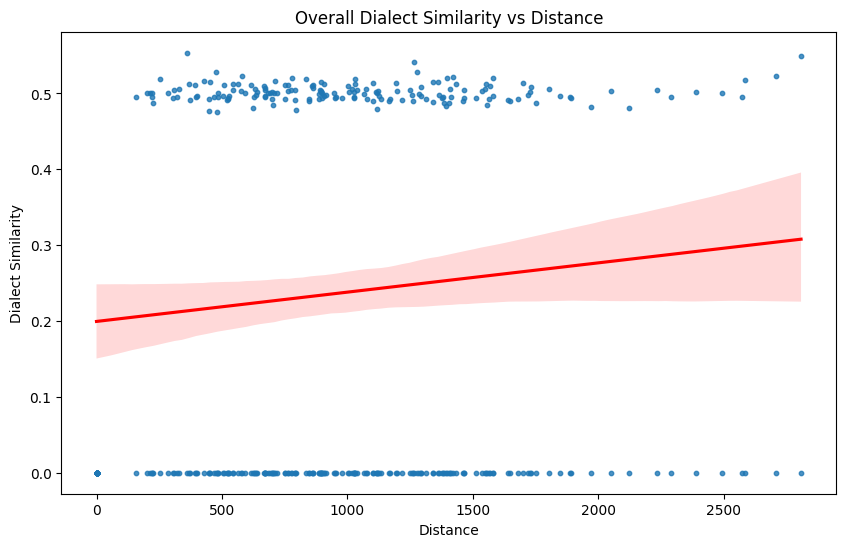

In [23]:
overal_sim = mean_sim.values.flatten().astype(float)
dis = distance.values.flatten().astype(float)
# Calculate the Pearson and Spearman correlation
pearson_corr, _ = pearsonr(dis, overal_sim)
print(f"Pearson Correlation: {pearson_corr}")
spearman_corr, _ = spearmanr(dis, overal_sim)
print(f"Spearman Correlation: is {spearman_corr}")
# Draw the scatter plot with a best fitting line
plt.figure(figsize=(10, 6))
sns.regplot(x=dis, y=overal_sim, scatter_kws={'s':10}, line_kws={"color":"red"})
plt.xlabel('Distance')
plt.ylabel('Dialect Similarity')
plt.title('Overall Dialect Similarity vs Distance')
plt.show()
